<a href="https://colab.research.google.com/github/AhmadZakkiZainalAbidin/Image_Classification_Multiclass__Transfer_Learning_Using_ResnetV2/blob/main/Transver_Learning_Cat_Dog_Rabbit_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pendahuluan**

**Transfer Learning**

Pada aplikasi computer vision, jumlah data akan sangat mempengaruhi performa model yang dibuat. Dengan data yang cenderung terbatas dapat mengakibatkan model akan bersifat overfit. Untuk mengatasi masalah ini selain kita dapat mengatasinya dengan augmentasi data. Kita juga dapat menggunakan model yang telah dilatih sebelumnya, Model ini dapat ditambahkan pada awal layer untuk mengenali bentuk-bentuk pada gambar

# **Membuat Model dengan Transfer Learning**

Untuk data set yang digunakan yaitu cat, dog, dan rabbit. Dimana untuk masing masing dataset dapat diakses pada link berikut.


*   https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification?select=train (untuk cat & dog)
*   https://www.kaggle.com/datasets/muniryadi/cat-vs-rabbit (untuk rabbit)

**Perlu diperhatikan kita akan menggunakan masing-masing 100 gambar dari keseluruhan data**


# **Melakukan Load data untuk Dataset Kaggle**

In [ ]:
#Melakukan install kaggle
!pip install -q kaggle

In [ ]:
#upload token kaggle.json untuk mengakses data set yang diperlukan
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmadzakkifa","key":"578420443fd5b9b066d38168eb595470"}'}

**Membuat direktori untuk kaggle**

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/ #lokasi token yang diupload
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list #mengecek apakah dataset kaggle dapat diakses

ref                                                                     title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                                     Online Food Dataset                                  3KB  2024-03-02 18:50:30          14874        306  0.9411765        
kanchana1990/world-air-quality-data-2024-updated                        World Air Quality Data 2024 (Updated)                2MB  2024-03-25 15:10:07           1467         40  1.0              
sukhmandeepsinghbrar/car-price-prediction-dataset                       Car Price Prediction Dataset                       141KB  2024-03-28 08:27:39            641         25  1.0              
prishasawhney/imdb-datase

**Mengunduh dataset yang diperlukan**

In [ ]:
#untuk cat & dog
!kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification

#untuk rabbit
!kaggle datasets download -d muniryadi/cat-vs-rabbit

 88% 57.0M/64.4M [00:00<00:00, 112MB/s] 
100% 64.4M/64.4M [00:00<00:00, 106MB/s]
 86% 57.0M/65.9M [00:00<00:00, 133MB/s]
100% 65.9M/65.9M [00:00<00:00, 139MB/s]


**Melakukan ekstraksi file yang telah diunduh**

In [ ]:
import zipfile

file_1 = '/content/cat-vs-rabbit.zip'
file_2 = '/content/cats-and-dogs-image-classification.zip'

zip_ref = zipfile.ZipFile(file_1, 'r')
zip_ref.extractall('/content')
zip_ref = zipfile.ZipFile(file_2, 'r')
zip_ref.extractall('/content')

zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/cats-and-dogs-image-classification.zip' mode='r'>>

In [ ]:
#Membuat folder baru
import os

os.mkdir('/content/uji_dir')
os.mkdir('/content/uji_dir/cat')
os.mkdir('/content/uji_dir/dog')
os.mkdir('/content/uji_dir/rabbit')

In [ ]:
#Mengcopy file dari masing-masing file train

!cp /content/train/cats/*.jpg /content/uji_dir/cat
!cp /content/train/dogs/*.jpg /content/uji_dir/dog
!cp /content/train-cat-rabbit/rabbit/*.jpg /content/uji_dir/rabbit

**Import Library Eksplorasi Gambar**

In [ ]:
import os
import cv2
import imghdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fnmatch

In [ ]:
def counting_dir(directory) :
  size_of_dir =[]
  for image_class in os.listdir(directory):
    image_path1 = os.path.join(directory, image_class)
    print(image_path1)
    count = len(fnmatch.filter(os.listdir(image_path1), '*.*'))
    size_of_dir.append(count)
    print(size_of_dir)

In [ ]:
counting_dir('/content/uji_dir')

/content/uji_dir/rabbit
[800]
/content/uji_dir/cat
[800, 279]
/content/uji_dir/dog
[800, 279, 278]


**Memilih 100 File yang diperlukan**

Pembagian File dilakukan menggunakan splitfolder dengan fungsi utama untuk membagi file train dan file test. Namun juga dapat digunakan untuk membagi folder dan filenya dengan jumlah yang spesifik

In [ ]:
!pip install split_folders

In [ ]:
cat_dog ='/content/train'
rabbit = '/content/train-cat-rabbit'

In [ ]:
!mkdir main_dir

In [ ]:
import splitfolders #Import library splitfolder

 #memilih basis direktori yaitu rps-cv-images dimana dalam folder ini terdapat 3 folder saja yang dibutuhkan yaitu rock, paper, dan scissor
splitfolders.ratio(cat_dog, output='/content/main_dir', seed= 1337, ratio=((100/270), (170/270))) #rasio pembagian train dan validation disesuaikan dengan perintah yaitu 6/4
splitfolders.ratio(rabbit, output='/content/main_dir', seed= 1337, ratio=((103/800), (697/800)))

Copying files: 557 files [00:00, 1460.53 files/s]
Copying files: 1600 files [00:00, 2918.76 files/s]


In [ ]:
#Removing unused directory
!rm /content/main_dir/train/cat/*.jpg
!rmdir /content/main_dir/train/cat

Melihat hasil dan jumlah pembagian file

In [ ]:
counting_dir('/content/main_dir/train')

/content/main_dir/train/dogs
[102]
/content/main_dir/train/rabbit
[102, 103]
/content/main_dir/train/cats
[102, 103, 103]


# **Explorasi Data**

Selanjutnya kita akan melihat informasi file yaitu lebar, tinggi, dan warna yang digunakan

In [ ]:
#Fungsi digunakan untuk mengakses file directory dan informasi data menggunakan cv2.mread
list_of_image_data =[]
def data_information(directory) :
  for image_class in os.listdir(directory) :
    for image in os.listdir(os.path.join(directory, image_class)) :
      path_image = os.path.join(directory, image_class, image)
      img = cv2.imread(path_image)
      list_of_image_data.append(img.shape)


In [ ]:
data_information('/content/main_dir/train')

In [ ]:
#Membuat informasi menjadi dataframe
df = pd.DataFrame(list_of_image_data, columns=['tinggi_pixel', 'lebar_pixel', 'RGB'])
df.describe()

,tinggi_pixel,lebar_pixel,RGB
count,308.000000,308.000000,308.0
mean,547.097403,745.178571,3.0
std,518.545369,693.421623,0.0
min,133.000000,170.000000,3.0
25%,300.000000,300.000000,3.0
50%,300.000000,318.000000,3.0
75%,637.250000,1024.000000,3.0
max,4096.000000,4169.000000,3.0


Semua data memiliki format RGB dan memiliki tinggi dan lebar pixel yang bervariasi

# **Melakukan Preprocessing Data**

In [ ]:
#Menginisiasi direktroy final
final_directory ='/content/main_dir/train'

**Melakukan Augmentasi data menggunakan Image Datagenerator Dengan Validation Split 0.3**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    fill_mode='nearest',
    validation_split = 0.3
)

In [ ]:
batch_size = 32
image_size = 224

train_generator = train_datagen.flow_from_directory(
    final_directory,
    target_size=(image_size, image_size),
    color_mode='rgb',
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'training'
)

validation_generator = train_datagen.flow_from_directory(
    final_directory,
    target_size=(image_size, image_size),
    color_mode='rgb',
    batch_size = batch_size,
    shuffle = False,
    class_mode='categorical',
    subset = 'validation'
)

Found 218 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


**Memperlihatkan Hasil Sample Augmentasi Data**

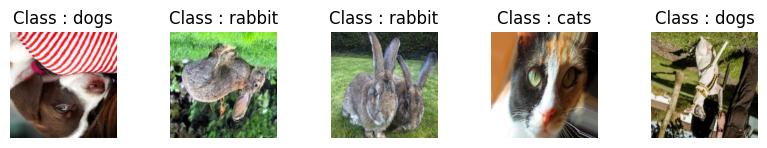

In [ ]:
import matplotlib.pyplot as plt

labels = [k for k in train_generator.class_indices]
gambar_sampel = train_generator.__next__()
gambar = gambar_sampel[0]
title = gambar_sampel[1]
plt.figure(figsize=(20, 20))

for i in range(5) :
  plt.subplot(10, 10, i+1)
  plt.subplots_adjust(hspace = 0.5, wspace=0.5)
  plt.imshow(gambar[i])
  plt.title(f'Class : {labels[np.argmax(title[i], axis =0)]}')
  plt.axis('off')

# **Membuat Model dengan Transver Learning**

Dilakukan Import model ResNet152v2 dengan menambahkan layer flatten dan 512 hidden layer. Klasifikasi input merupakan klasifikasi tiga kelas sehingga pada layer terakhir menggunakan softmax activation.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2

model = tf.keras.models.Sequential([
    #Resnet Model
    ResNet152V2(weights ='imagenet', include_top = False, input_tensor = Input(shape=(224, 224, 3))),
    #Layer Flatten
    tf.keras.layers.Flatten(),
    #512 neuron hidden layer
    tf.keras.layers.Dense(512, activation ='relu'),
    tf.keras.layers.Dense(256, activation ='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.layers[0].trainable =False

234545216/234545216 [==============================] - 3s 0us/step


In [ ]:
model.summary() #Menampilkan informasi model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 109844483 (419.02 MB)
Trainable params: 51512835 (196.51 MB)
Non-trainable params: 58331648 (222.52 MB)
_________________________________________________________________


**Membuat Callbacks**

Berbeda dengan callbacks pada project sebelumnya, Pada callbacks ini digunakan yaitu EarlyStopping (untuk menghentikan traning model apabila progress score tetap berjalan ditempat). Lalu untuk ModelCheckpoint berfungsi menyimpan model pada hasil traning terbaik. Pengaturan dilakukan dengan memonitor val_loss terbaik dari model

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

model_name = 'multiclassification_resnet.h5'
checkpoint = ModelCheckpoint(
    model_name,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    verbose = 2
)

earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0,
    patience = 30,
    verbose =2,
    restore_best_weights=True
)

**Melakukan Proses Compile Model**

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate= 0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

# **Melakukan Pelatihan Model**

In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=1000,
                    callbacks=[checkpoint, earlystopping],
                    verbose=2)

Epoch 1/1000

Epoch 1: val_loss improved from inf to 3.21976, saving model to multiclassification_resnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 - 50s - loss: 17.4837 - accuracy: 0.5596 - val_loss: 3.2198 - val_accuracy: 0.8111 - 50s/epoch - 7s/step
Epoch 2/1000

Epoch 2: val_loss improved from 3.21976 to 1.45990, saving model to multiclassification_resnet.h5
7/7 - 21s - loss: 2.3581 - accuracy: 0.8532 - val_loss: 1.4599 - val_accuracy: 0.8667 - 21s/epoch - 3s/step
Epoch 3/1000

Epoch 3: val_loss did not improve from 1.45990
7/7 - 6s - loss: 1.8644 - accuracy: 0.9128 - val_loss: 5.7444 - val_accuracy: 0.7667 - 6s/epoch - 848ms/step
Epoch 4/1000

Epoch 4: val_loss did not improve from 1.45990
7/7 - 6s - loss: 1.5446 - accuracy: 0.9220 - val_loss: 2.3208 - val_accuracy: 0.8333 - 6s/epoch - 841ms/step
Epoch 5/1000

Epoch 5: val_loss did not improve from 1.45990
7/7 - 6s - loss: 1.8955 - accuracy: 0.9128 - val_loss: 4.6339 - val_accuracy: 0.8333 - 6s/epoch - 809ms/step
Epoch 6/1000

Epoch 6: val_loss did not improve from 1.45990
7/7 - 7s - loss: 1.1375 - accuracy: 0.9495 - val_loss: 4.2958 - val_accuracy: 0.8333 - 7s/epoch - 1s

# **Plot Hasil Train Model dan Pengujian Model**

**Plot Hasil Traning dan Testing**

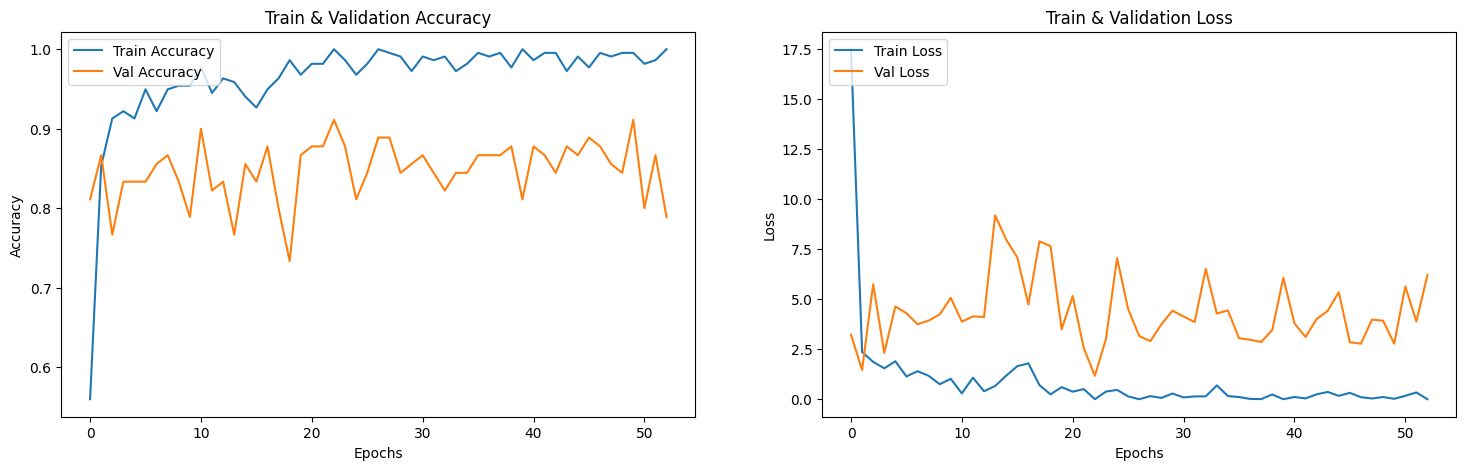

In [ ]:
import matplotlib.pyplot as plt

def show_graph(history) :
  fig, ax= plt.subplots(1, 2, figsize=(18,5))
  ax[0].set_title('Train & Validation Accuracy')
  ax[0].plot(history.epoch, history.history['accuracy'], label='Train Accuracy')
  ax[0].plot(history.epoch, history.history['val_accuracy'], label='Val Accuracy')
  ax[0].legend(loc='upper left')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')

  ax[1].set_title('Train & Validation Loss')
  ax[1].plot(history.epoch, history.history['loss'], label='Train Loss')
  ax[1].plot(history.epoch, history.history['val_loss'], label='Val Loss')
  ax[1].legend(loc='upper left')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')

show_graph(history)

**Pengujian Model Klasifikasi Gambar**

In [ ]:
best_model = tf.keras.models.load_model('multiclassification_resnet.h5')

In [ ]:
y_test = validation_generator.classes
y_pred_val = best_model.predict(validation_generator)
y_pred_val =np.argmax(y_pred_val, axis=1)

3/3 [==============================] - 4s 747ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred_val, target_names =labels))

              precision    recall  f1-score   support

        cats       0.82      0.90      0.86        30
        dogs       0.88      0.93      0.90        30
      rabbit       0.96      0.80      0.87        30

    accuracy                           0.88        90
   macro avg       0.88      0.88      0.88        90
weighted avg       0.88      0.88      0.88        90



**Kesimpulan Akhir**

Dari model yang telah dibuat ini menunjukkan model memiliki tingkat akurasi yang tinggi untuk validasi dan train. Namun, perlu diperhatikan model yang digunakan memiliki nilai validation loss yang sangat tinggi. Hal ini masih dimungkinkan disebabkan oleh data train yang dibatasi untuk klasifikasi 3 klass

# **PapanTulis (Unused Code)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

IMG_SHAPE = (image_size, image_size) + (3, )

model2 = tf.keras.models.Sequential(
    #MobileNetV2 Model
    MobileNetV2(weights ='imagenet', include_top = False, input_shape = IMG_SHAPE),
    #Layer Flatten
    tf.keras.layers.Flatten(),
    #512 neuron hidden layer
    tf.keras.layers.Dense(512, activation ='relu'),
    tf.keras.layers.Dense(256, activation ='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
)

model2.layers[0].trainable =False

TypeError: Sequential.__init__() takes from 1 to 3 positional arguments but 6 were given

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               32113152  
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 34503235 (131.62 MB)
Trainable params: 32245251 (123.01 MB)
Non-trainable params: 2257984 (8.61 MB)
______

In [ ]:
model2.summary()

In [ ]:
import splitfolders #Import library splitfolder

 #memilih basis direktori yaitu rps-cv-images dimana dalam folder ini terdapat 3 folder saja yang dibutuhkan yaitu rock, paper, dan scissor
splitfolders.ratio(cat_dog, output='/content/cat_dog', seed= 1337, ratio=((100/270), (170/270))) #rasio pembagian train dan validation disesuaikan dengan perintah yaitu 6/4
splitfolders.ratio(rabbit, output='/content/rabbit', seed= 1337, ratio=((103/800), (697/800)))

Copying files: 557 files [00:00, 3210.00 files/s]
Copying files: 1600 files [00:00, 4523.71 files/s]


In [ ]:
#Membuat folder baru
import os

os.mkdir('/content/main_dir')
os.mkdir('/content/main_dir/cats')
os.mkdir('/content/main_dir/dogs')
os.mkdir('/content/main_dir/rabbits')

In [ ]:
#Mengcopy file dari masing-masing file train

!cp /content/cat_dog/train/cats/*.jpg /content/main_dir/cats
!cp /content/cat_dog/train/dogs*.jpg /content/main_dir/dogs
!cp /content/rabbit/train/rabbit*.jpg /content/main_dir/rabbits

In [ ]:
counting_dir('/content/train')

In [ ]:
size_of_dir = []

In [ ]:
count = len(fnmatch.filter(os.listdir('/content/main_dir/train/cats'), '*.*'))
size_of_dir.append(count)

In [ ]:
count = len(fnmatch.filter(os.listdir('/content/main_dir/train/dogs'), '*.*'))
size_of_dir.append(count)

In [ ]:
count = len(fnmatch.filter(os.listdir('/content/main_dir/train/rabbit'), '*.*'))
size_of_dir.append(count)

In [ ]:
size_of_dir

[103, 102, 103]

In [ ]:
list_of_tuples= []

def information_data(dir_data) :
  for image_class in os.listdir(dir_data):
    for image in os.listdir(os.path.join(dir_data, image_class)) :
      image_path = os.path.join(dir_data, image_class, image)
      img = cv2.imread(image_path)
      list_of_tuples.append(img.shape)

size_of_dir = []

def counting_dir(directory) :
  for image_class in os.listdir(directory):
    for image in os.listdir(os.path.join(directory, image_class)) :
      image_path1 = os.path.join(directory, image_class, image)
      count = len(fnmatch.filter(os.listdir(image_path1), '*.*'))
      size_of_dir.append(count)

In [ ]:
size_of_dir =[]

'''
def counting_dir(directory) :
  for image_loc in os.listdir(directory):
    count = len(fnmatch.filter(os.listdir(directory), '*.*'))
    size_of_dir.append(count)

def counting_dir(directory) :
  for image_class in os.listdir(directory):
    for image in os.listdir(os.path.join(directory, image_class)) :
      image_path1 = os.path.join(directory, image_class, image)
      print(image_path1)
'''
def counting_dir(directory) :
  for image_class in os.listdir(directory):
    image_path1 = os.path.join(directory, image_class)
    print(image_path1)
    count = len(fnmatch.filter(os.listdir(image_path1), '*.*'))
    size_of_dir.append(count)
    print(size_of_dir)

In [ ]:
counting_dir('/content/main_dir')

/content/main_dir/dog
[278]
/content/main_dir/cat
[278, 279]
/content/main_dir/rabbit
[278, 279, 800]


NameError: name 'image_path1' is not defined

In [ ]:
size_directory =[]

def counting_dir(directory) :
  for image_class in os.listdir(dir_data) :
    count = len(fmatch.filter(os.listdir(di)))

In [ ]:
kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification
#for cat & dog

In [ ]:
kaggle datasets download -d muniryadi/cat-vs-rabbit
#for rabbit

In [ ]:
class Callback(tf.keras.callbacks.Callback) :
  def on_epoch_end(self, epoch, logs={}) :
    if(logs.get('accuracy') > 0.8 and logs.get('val_accuracy') > 0.8) :
      print('\nSelamat Akurasi >80% tercapai untuk Training dan Validasi !!!!!')
      self.model.stop_training =True
callbacks = Callback()